# Execute first

In [16]:
#add the main directory to the path for access to feateng.py modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#import the other necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from airbnb import feateng
from sklearn.preprocessing import LabelEncoder, label_binarize, MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import seaborn as sns
%matplotlib inline

#initialize dict for saving roc_micro over models
roc_macro_all = {}

#modeling functions
def ndcg_score(Y_true, pred_prob, k):
    """
    Compute the normalized discounted cumulative gain.
    
    Params
        Y_true:    Correct class number.  Numbers must correspond to columns of pred_prob (e.g., transform function of sklearn labelEncoder).
        pred_prob: predicted probability for each class.
        k:         k parameter determines the number of ranks to evaluate.
    Returns
        ndcg: average normalized discounted cumulative gain over observations
    """                        
    #get number of classes and observations from dimensions of pred_prob
    num_classes = np.shape(pred_prob)[1]
    num_obs = np.shape(pred_prob)[0]
    #error checking, number of classes must be >= k
    if num_classes<k:
        print('Error: number of classes must be >= k. Returning NaN')
        ndcg = np.nan
        return ndcg
    #get the sorted columns of pred_prob (increasing), grab last k, flip order for best to worst
    top_k = np.argsort(pred_prob,axis=1)[:,-k:][:,::-1]
    #compute the relevance: tile Y_true, transpose Y_true to
    #match the rows of top_k, do elementwise comparison to top_k,
    #convert boolean to int.
    rel = np.equal(top_k,np.tile(Y_true,(k,1)).T).astype(int)
    #loop over columns and compute ndcg for all observations in parallel
    ndcg = np.zeros([num_obs,])
    for i in np.arange(k)+1:
        ndcg=ndcg+((2**rel[:,i-1])-1)/np.log2(i+1)
    #average over obsrvations
    ndcg = np.mean(ndcg)
    return ndcg

def modelResults(result,X,Y,le):
    """
    Compute model predictions on the training and holdout data and some summary statistics.
    """
    pred_prob = {}; pred = {}; roc_macro = {}; roc_micro = {}; conf_mat = {}; ndcg = {};acc = {}
    for k in X.keys():
        pred_prob[k] = result.predict_proba(X[k])
        pred[k] = result.predict(X[k])
        acc[k] = np.mean(pred[k] == Y[k])
        labels_bin = label_binarize(Y[k],np.arange(len(le.classes_)))
        if np.sum( np.sum(labels_bin,0) == 0) == 0:
            if np.shape(pred_prob[k])[1] == 2:
                roc_macro[k] = roc_auc_score(labels_bin, pred_prob[k][:,1], average = 'macro')
            else:
                roc_macro[k] = roc_auc_score(labels_bin, pred_prob[k], average = 'macro')
        else:
            roc_macro[k] = np.nan
            print "Too few category members for roc_macro for data set %s, setting as NaN." % (k)
        if np.shape(pred_prob[k])[1] == 2:
            roc_micro[k] = roc_auc_score(labels_bin, pred_prob[k][:,1], average = 'micro')
        else:
            roc_micro[k] = roc_auc_score(labels_bin, pred_prob[k], average = 'micro')
        ndcg[k] = ndcg_score(Y[k], pred_prob[k], 5)
        conf_mat[k] = confusion_matrix(Y[k], pred[k])
        #print summary statistics
        print ("%s: Accuracy: %2.4f ") % (k, acc[k])
        print ("%s: AUROC micro: %2.4f ") % (k, roc_micro[k])
        print ("%s: AUROC macro: %2.4f ") % (k, roc_macro[k])
        print ("%s: NDCG: %2.2f ") % (k, ndcg[k])
    return pred_prob, pred, roc_macro, roc_micro, conf_mat, acc

def plotConfMat(conf_mat, bin_labels,vmax=None):
    """
     Plot the confusion matrix for holdout data
    """
    fig = plt.figure()
    if not vmax:
        ax = sns.heatmap(conf_mat,vmin=0)
    else:
        ax = sns.heatmap(conf_mat,vmax=vmax,vmin=0,cmap="Greys")    
    ax.set_xticklabels(bin_labels)
    ax.set_yticklabels(revList(bin_labels),rotation=0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Observed')
    
    return ax

def confMatProb(pred_prob,y):
    """
    Generate confusion matrix with probability entries.

    Params:
    - pred_prob, 2D array, predicted probabilities observations x classes
    - y, array, correct class (category)
    Returns:
    - conf_mat_prob, 2D array (classes x classes), predicted probability for each class (rows = observed, cols = predicted)
    """
    num_obs = pred_prob.shape[0]
    num_classes = pred_prob.shape[1]
    conf_mat_prob = np.ones([num_classes,num_classes])*np.nan
    for o in np.arange(num_classes):
        for p in np.arange(num_classes):
            conf_mat_prob[o,p] = np.mean(pred_prob[y==o,p])
    return conf_mat_prob

def revList(list):
    "Reverse the order of a list."
    rev_list = list[np.arange(len(list),0,-1)-1]
    return rev_list

def plotObsPred(pred,obs,bins_,bin_labels):
    """
    Plot the frequency distribution of observed and predicted classes.
    """
    fig = plt.figure()
    ax = fig.add_axes([.2,.2,.6,.6])
    ax.hist(pred, bins=bins_-0.5, color='b', alpha=0.5)
    ax.hist(obs, bins=bins_-0.5, color='g', alpha=0.5)
    ax.set_xticks(bins_)
    ax.set_xticklabels(bin_labels,rotation=45)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Country Destionation')
    ax.legend(['Pred','Obs'],loc = (1,1))

def split_train_test(df_train,labels):
    """
    Split training data into train and holdout sets (last 10% of data).
    """
    n_train = np.shape(df_train)[0]
    X = {'train': [],'holdout': []} #features
    Y = {'train':[],'holdout': []} #labels
    p10 = int(0.1*n_train)
    X['holdout'] = df_train.iloc[-p10:]
    Y['holdout'] = labels[-p10:]
    X['train'] = df_train.iloc[:(n_train-p10)]
    Y['train'] = labels[:(n_train-p10)]
    return X,Y

def get_sub(pred,id_test,file_name,le):
    """
    Given matrix of predicted probabilities, print a .csv submission file.

    Params:
    - pred, array, observations x classes matrix of prediction probabilities
    - file_name, str, name of .csv file to save for submission
    """
    #Taking the 5 classes with highest probabilities
    ids = []  #list of ids
    cts = []  #list of countries
    for i in range(len(id_test)):
        idx = id_test[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(pred[i])[::-1])[:5].tolist()
    #Generate submission
    sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
    sub.to_csv(file_name,index=False)

# Binary classification: NDF vs any booking. 
## L1-regularized logistic regression

In [18]:
#Load the data and generate features
debug = False
merge_classes = ['other','US','FR','CA','GB','ES','IT','PT','NL','DE','AU']
rm_classes = []
rescale_predictors = True
add_sessions = 'bin'
training_data = '../data/train_users_2.csv'
test_data = '../data/test_users.csv'
add_logreg_filename = []
df_train, df_test, labels, id_train, id_test = feateng.feateng1(training_data,test_data,add_sessions,rm_classes,merge_classes,add_logreg_filename,rescale_predictors,debug)

#print some information about the data
n_train, n_feats = np.shape(df_train)
n_test = np.shape(df_test)[0]
n_labels = np.shape(labels)[0]
print "%d training observations" % (n_train)
print "%d test observations" % (n_test)
print "%d features" % (n_feats)
print "%d labels" % (n_labels)

# encode labels as integers
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels).ravel()
bins_ = np.arange(len(le.classes_))
bin_labels = le.inverse_transform(bins_)

#split training data into train and holdout sets (last 10% of data)
X,Y = split_train_test(df_train,labels)

Loading data...

Done
Feature engineering...
    formatting date_account_created...
    formatting timestamp_first_active
    formatting age
    one-hot-feature encoding
213451 training observations
62096 test observations
346 features
213451 labels


In [19]:
import pickle
from sklearn.externals import joblib
# load the model from disk
filename = '../output/logregModel_binsesh_merged.sav'
loaded_model = joblib.load(filename)
result = loaded_model
pred_prob, pred, roc_macro, roc_micro, conf_mat, acc = modelResults(result,X,Y,le)

Error: number of classes must be >= k. Returning NaN
holdout: Accuracy: 0.7136 
holdout: AUROC micro: 0.7516 
holdout: AUROC macro: 0.7516 
holdout: NDCG: nan 
Error: number of classes must be >= k. Returning NaN
train: Accuracy: 0.6872 
train: AUROC micro: 0.7223 
train: AUROC macro: 0.7223 
train: NDCG: nan 


In [20]:
#get a table of all non-zero coefficients
coef_list = result.coef_[0]
d = {'coefs': coef_list,'feats': X['train'].columns}
coef_df = pd.DataFrame(d)
coef_df = coef_df[coef_df['coefs'] != 0]
I = np.argsort(coef_df['coefs'])
coef_df_sorted = coef_df.iloc[I]
#add some tidy labels
clean_labels = ['Age: missing',
                'Signup method: Facebook',
                'First browser: missing',
                'Date account created: year',
                'First affiliate tracked: OMG',
                'Gender: missing',
                'Affiliate channel: Direct',
                'First browser: Firefox',
                'Signup app: Web',
                'First browser: Chrome',
                'First affiliate tracked: Untracked',
                'First device: Mac Desktop',
                'Previous web page #3',
                'Signup method: Basic']
coef_df_sorted['clean_labels'] = clean_labels
coef_df_sorted

/Users/purcelba/anaconda/envs/Python2.7/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,coefs,feats,clean_labels
345,-1.537173,age_-1,Age: missing
196,-0.435260,signup_method_facebook,Signup method: Facebook
290,-0.132291,first_browser_-1,First browser: missing
1,-0.129342,dac_year,Date account created: year
273,-0.049447,first_affiliate_tracked_omg,First affiliate tracked: OMG
191,-0.007021,gender_-1,Gender: missing
245,0.011278,affiliate_channel_direct,Affiliate channel: Direct
307,0.011922,first_browser_Firefox,First browser: Firefox
298,0.084976,first_browser_Chrome,Signup app: Web
279,0.086269,signup_app_Web,First browser: Chrome


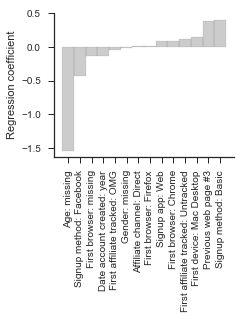

In [22]:
#plot it
save_on = True
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.0)
fig = plt.figure(figsize=(5,5))
    #generate the histogram
ax = fig.add_axes([.3,.5,.5,.4])
x = np.arange(np.shape(coef_df_sorted)[0])
y = coef_df_sorted['coefs']
width = 1.0
ax.bar(x,y,width,color=(0,0,0),alpha=0.2,edgecolor='k')
    #label the histogram
ax.set_ylabel('Regression coefficient')
ax.set_xticks(x)
ax.set_xticklabels((coef_df_sorted['clean_labels']))
plt.tick_params(direction = 'out')
plt.xticks(rotation = 90)
sns.despine()
if save_on:
    plt.savefig('beta_cofficient_histogram.png',dpi=600,edgecolor='k')

# Multiclass classification with binary sessions data

## Load the data and generate features

In [6]:
#Load the data and generate features
debug = False
merge_classes = []
rm_classes = []
add_sessions = 'bin'
training_data = '../data/train_users_2.csv'
test_data = '../data/test_users.csv'
add_logreg_filename = []
rescale_predictors = True
df_train, df_test, labels, id_train, id_test = feateng.feateng1(training_data,test_data,add_sessions,rm_classes,merge_classes,add_logreg_filename,rescale_predictors,debug)

#print some information about the data
n_train, n_feats = np.shape(df_train)
n_test = np.shape(df_test)[0]
n_labels = np.shape(labels)[0]
print "%d training observations" % (n_train)
print "%d test observations" % (n_test)
print "%d features" % (n_feats)
print "%d labels" % (n_labels)

# encode labels as integers
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels).ravel()
bins_ = np.arange(len(le.classes_))
bin_labels = le.inverse_transform(bins_)

#split training data into train and holdout sets (last 10% of data)
X,Y = split_train_test(df_train,labels)


Loading data...

Done
Feature engineering...
    formatting date_account_created...
    formatting timestamp_first_active
    formatting age
    one-hot-feature encoding
213451 training observations
62096 test observations
346 features
213451 labels


## Regularized logistic regression

In [7]:
import pickle
from sklearn.externals import joblib
# load the model from disk
filename = '../output/logregModel_binsesh.sav'
loaded_model = joblib.load(filename)
result = loaded_model
pred_prob, pred, roc_macro, roc_micro, conf_mat, acc = modelResults(result,X,Y,le)
roc_macro_all['logregModel_binsesh'] = roc_macro['holdout']

holdout: Accuracy: 0.6515 
holdout: AUROC micro: 0.9464 
holdout: AUROC macro: 0.6598 
holdout: NDCG: 0.83 
train: Accuracy: 0.6246 
train: AUROC micro: 0.9396 
train: AUROC macro: 0.6400 
train: NDCG: 0.82 


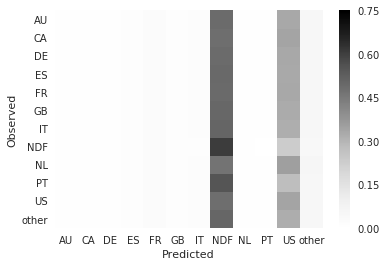

In [17]:
#plot conf matrix of probabilities
save_on = True
conf_mat_prob = confMatProb(pred_prob['holdout'], Y['holdout'])
ax = plotConfMat(conf_mat_prob,bin_labels,vmax=0.75)
if save_on:
    plt.savefig('confmat_logreg_binsesh.pdf', dpi=600,edgecolor='k')

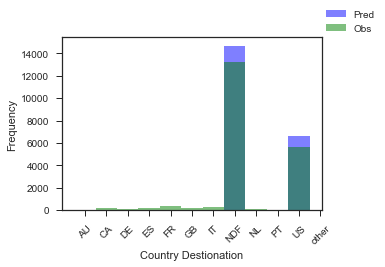

In [254]:
plotObsPred(predict,y_true,np.arange(len(le.classes_)),le.inverse_transform(bins_))

## XGBoost

In [244]:
import pickle
from sklearn.externals import joblib
# load the model from disk
filename = '../output/xgbModel_binsesh.sav'
result = joblib.load(filename)
result.fit(X['train'],Y['train'])
pred_prob, pred, roc_macro, roc_micro, conf_mat, acc = modelResults(result,X,Y,le)
roc_macro_all['xgbModel_binsesh'] = roc_macro['holdout']

holdout: Accuracy: 0.6963 
holdout: AUROC micro: 0.9532 
holdout: AUROC macro: 0.7005 
holdout: NDCG: 0.85 
train: Accuracy: 0.6400 
train: AUROC micro: 0.9425 
train: AUROC macro: 0.6519 
train: NDCG: 0.83 


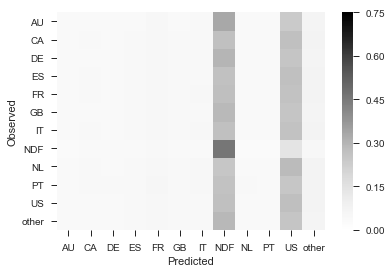

In [247]:
#plot conf matrix of probabilities
save_on=True
conf_mat_prob = confMatProb(pred_prob['holdout'], Y['holdout'])
plotConfMat(conf_mat_prob,bin_labels,vmax=0.75)
if save_on:
    plt.savefig('confmat_xgb_binsesh.pdf', dpi=600,edgecolor='k')

### plotObsPred(pred['holdout'],Y['holdout'],np.arange(len(le.classes_)),le.inverse_transform(bins_))

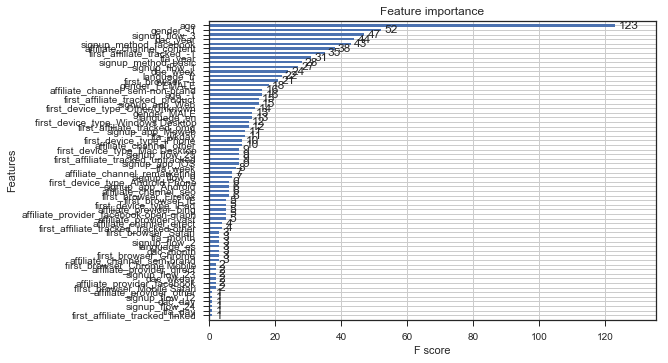

In [51]:
#we can also get feature importance ranks out of XGBoost
#there is a built in function to do this.  very cool.
feat_imp = result.feature_importances_
from xgboost import plot_importance
plot_importance(result, height=0.5)

#interesting to see that the results are in general agreement with logistic regression as to which 
#features are the most important.  Surprising that age was missed for logistic regressino which only
#picked up on the missing value feature.

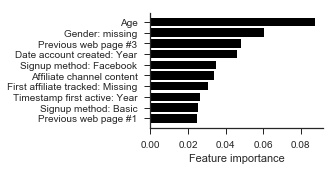

In [136]:
#Now let's do a manual version so that we can limit the number of features
save_on=1
#get feature names and importances
feat_names = X['holdout'].columns
feat_imp = result.feature_importances_
#sort
I = np.argsort(feat_imp)
feat_names = feat_names[I]
feat_imp = feat_imp[I]
#hard code some clean labels
clean_labels = ['Age','Gender: missing','Previous web page #3', 'Date account created: Year',
                'Signup method: Facebook','Affiliate channel content','First affiliate tracked: Missing',
                'Timestamp first active: Year', 'Signup method: Basic','Previous web page #1']
#plot
n_feats = 10 #how many top features to plot?  Fix to 10 if using clean labels
fig = plt.figure()
fig.add_axes([.4,.2,.4,.4])
ax = plt.barh(range(n_feats),feat_imp[-n_feats:],tick_label=clean_labels[::-1],color='k')
plt.xlabel('Feature importance')
sns.set_style("ticks")
sns.despine()
#save
if save_on:
    plt.savefig('xgb_feature_importance_barh.png',dpi=600,edgecolor='k')

## MLP

In [221]:
import keras
#load the model
filename = '../output/kerasModel_binsesh.h5'
model = keras.models.load_model(filename)
#generate predictions
#format the data for fitting
x_train = np.array(X['train'])
y_train = keras.utils.to_categorical(Y['train'], num_classes=12)
x_holdout = np.array(X['holdout'])
y_holdout = keras.utils.to_categorical(Y['holdout'], num_classes=12)


In [242]:
#train
pred_prob = model.predict(x_train)
predict = np.argmax(pred_prob,1)
acc = np.mean(predict==np.argmax(y_train,1))
roc_macro = roc_auc_score(y_train, pred_prob, average = 'macro')
roc_micro = roc_auc_score(y_train, pred_prob, average =  'micro')
y_true = np.argmax(y_train,1)
k=5
ndcg = ndcg_score(y_true, pred_prob, k)
print "train: Accuracy: %2.4f" % (acc)
print "train: roc_macro: %2.4f" % (roc_macro)
print "train: roc_micro: %2.4f" % (roc_micro)
print "train: ndcg: %2.4f" % (ndcg)
#holdout
pred_prob = model.predict(x_holdout)
predict = np.argmax(pred_prob,1)
acc = np.mean(predict==np.argmax(y_holdout,1))
roc_macro = roc_auc_score(y_holdout, pred_prob, average = 'macro')
roc_micro = roc_auc_score(y_holdout, pred_prob, average =  'micro')
roc_macro_all['kerasModel_binsesh'] = roc_macro
y_true = np.argmax(y_holdout,1)
k=5
ndcg = ndcg_score(y_true, pred_prob, k)
print "holdout: Accuracy: %2.4f" % (acc)
print "holdout: roc_macro: %2.4f" % (roc_macro)
print "holdout: roc_micro: %2.4f" % (roc_micro)
print "holdout: ndcg: %2.4f" % (ndcg)


train: Accuracy: 0.6490
train: roc_macro: 0.7004
train: roc_micro: 0.9474
train: ndcg: 0.8309
holdout: Accuracy: 0.7011
holdout: roc_macro: 0.7383
holdout: roc_micro: 0.9569
holdout: ndcg: 0.8530


In [246]:
#plot confusion matrix
save_on = True
conf_mat_prob = confMatProb(pred_prob,np.argmax(y_holdout,1))
plotConfMat(conf_mat_prob,bin_labels,vmax=0.75)
if save_on:
    plt.savefig('confmat_mlp_binsesh.pdf', dpi=600,edgecolor='k')

AttributeError: 'dict' object has no attribute 'shape'

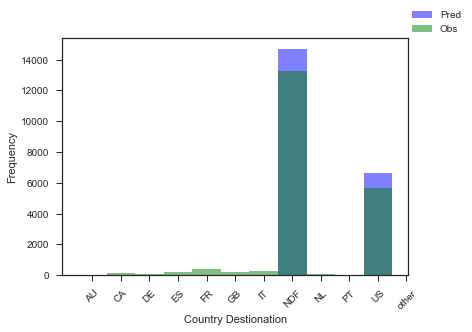

In [284]:
plotObsPred(predict,y_true,np.arange(len(le.classes_)),le.inverse_transform(bins_))

# Multiclass classification with binary sessions data with stacked logistic regression merged predictions

## Load the data and generate features

In [299]:
#Load the data and generate features
debug = False
merge_classes = []
rm_classes = []
add_sessions = 'bin'
training_data = '../data/train_users_2.csv'
test_data = '../data/test_users.csv'
add_logreg_filename = '../output/logregModel_merged_classes.sav'
df_train, df_test, labels, id_train, id_test = feateng.feateng1(training_data,test_data,add_sessions,rm_classes,merge_classes,add_logreg_filename,rescale_predictors,debug)

#print some information about the data
n_train, n_feats = np.shape(df_train)
n_test = np.shape(df_test)[0]
n_labels = np.shape(labels)[0]
print "%d training observations" % (n_train)
print "%d test observations" % (n_test)
print "%d features" % (n_feats)
print "%d labels" % (n_labels)

# encode labels as integers
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels).ravel()
bins_ = np.arange(len(le.classes_))
bin_labels = le.inverse_transform(bins_)

#split training data into train and holdout sets (last 10% of data)
X,Y = split_train_test(df_train,labels)


Loading data...

Done
Feature engineering...
    formatting date_account_created...
    formatting timestamp_first_active
    formatting age
    one-hot-feature encoding
213451 training observations
62096 test observations
347 features
213451 labels


## Logistic regression

In [300]:
import pickle
from sklearn.externals import joblib
# load the model from disk
filename = '../output/logregModel_binsesh_addLog.sav'
result = joblib.load(filename)
pred_prob, pred, roc_macro, roc_micro, conf_mat, acc = modelResults(result,X,Y,le)
roc_macro_all['logregModel_binsesh_addLog'] = roc_macro

holdout: Accuracy: 0.6247 
holdout: AUROC micro: 0.9456 
holdout: AUROC macro: 0.6599 
holdout: NDCG: 0.82 
train: Accuracy: 0.6136 
train: AUROC micro: 0.9385 
train: AUROC macro: 0.6395 
train: NDCG: 0.82 


## XGBoost

In [301]:
import pickle
from sklearn.externals import joblib
# load the model from disk
filename = '../output/xgbModel_binsesh_addLog.sav'
result = joblib.load(filename)
result.fit(X['train'],Y['train'])
pred_prob, pred, roc_macro, roc_micro, conf_mat, acc = modelResults(result,X,Y,le)
roc_macro_all['xgbModel_binsesh_addLog'] = roc_macro['holdout']

holdout: Accuracy: 0.6970 
holdout: AUROC micro: 0.9545 
holdout: AUROC macro: 0.7126 
holdout: NDCG: 0.85 
train: Accuracy: 0.6421 
train: AUROC micro: 0.9434 
train: AUROC macro: 0.6627 
train: NDCG: 0.83 


NameError: name 'roc_macros' is not defined

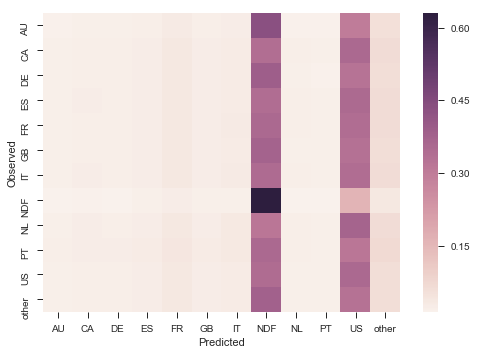

In [202]:
#plot conf matrix of probabilities
conf_mat_prob = confMatProb(pred_prob['holdout'], Y['holdout'])
plotConfMat(conf_mat_prob,bin_labels)

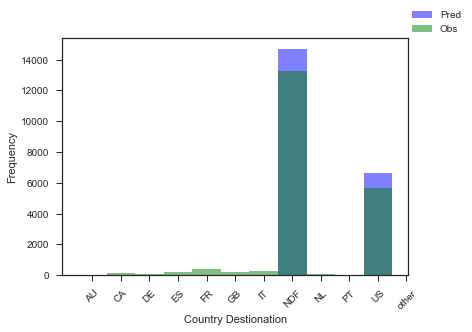

In [203]:
plotObsPred(predict,y_true,np.arange(len(le.classes_)),le.inverse_transform(bins_))

## MLP

In [309]:
import keras
#load the model
filename = '../output/kerasModel_binsesh_addLog.h5'
model = keras.models.load_model(filename)
#generate predictions
#format the data for fitting
x_train = np.array(X['train'])
y_train = keras.utils.to_categorical(Y['train'], num_classes=12)
x_holdout = np.array(X['holdout'])
y_holdout = keras.utils.to_categorical(Y['holdout'], num_classes=12)


In [311]:
#train
pred_prob = model.predict(x_train)
predict = np.argmax(pred_prob,1)
acc = np.mean(predict==np.argmax(y_train,1))
roc_macro = roc_auc_score(y_train, pred_prob, average = 'macro')
roc_micro = roc_auc_score(y_train, pred_prob, average =  'micro')
y_true = np.argmax(y_train,1)
k=5
ndcg = ndcg_score(y_true, pred_prob, k)
print "train: Accuracy: %2.4f" % (acc)
print "train: roc_macro: %2.4f" % (roc_macro)
print "train: roc_micro: %2.4f" % (roc_micro)
print "train: ndcg: %2.4f" % (ndcg)
#holdout
pred_prob = model.predict(x_holdout)
predict = np.argmax(pred_prob,1)
acc = np.mean(predict==np.argmax(y_holdout,1))
roc_macro = roc_auc_score(y_holdout, pred_prob, average = 'macro')
roc_micro = roc_auc_score(y_holdout, pred_prob, average =  'micro')
roc_macro_all['kerasModel_binsesh_addLog'] = roc_macro
y_true = np.argmax(y_holdout,1)
k=5
ndcg = ndcg_score(y_true, pred_prob, k)
print "holdout: Accuracy: %2.4f" % (acc)
print "holdout: roc_macro: %2.4f" % (roc_macro)
print "holdout: roc_micro: %2.4f" % (roc_micro)
print "holdout: ndcg: %2.4f" % (ndcg)


train: Accuracy: 0.6467
train: roc_macro: 0.6966
train: roc_micro: 0.9465
train: ndcg: 0.8301
holdout: Accuracy: 0.7008
holdout: roc_macro: 0.7340
holdout: roc_micro: 0.9565
holdout: ndcg: 0.8530


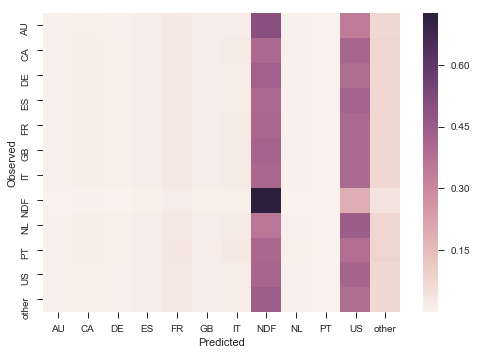

In [217]:
#plot confusion matrix
conf_mat_prob = confMatProb(pred_prob,np.argmax(y_holdout,1))
plotConfMat(conf_mat_prob,bin_labels)

In [218]:
#generate submission file
#format the test data.
x_test = np.array(df_test)
pred_test = model.predict(x_test)
#generate submission file
get_sub(pred_test,id_test,'keras_binsesh_addLog.csv',le)

# Multiclass classification with no sessions data

## Load the data and generate features

In [3]:
#Load the data and generate features
debug = False
merge_classes = []
rm_classes = []
rescale_predictors = True
add_sessions = 'none'
training_data = '../data/train_users_2.csv'
test_data = '../data/test_users.csv'
add_logreg_filename = []
df_train, df_test, labels, id_train, id_test = feateng.feateng1(training_data,test_data,add_sessions,rm_classes,merge_classes,add_logreg_filename,rescale_predictors,debug)

#print some information about the data
n_train, n_feats = np.shape(df_train)
n_test = np.shape(df_test)[0]
n_labels = np.shape(labels)[0]
print "%d training observations" % (n_train)
print "%d test observations" % (n_test)
print "%d features" % (n_feats)
print "%d labels" % (n_labels)

# encode labels as integers
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels).ravel()
bins_ = np.arange(len(le.classes_))
bin_labels = le.inverse_transform(bins_)

#split training data into train and holdout sets (last 10% of data)
X,Y = split_train_test(df_train,labels)


Loading data...

Done
Feature engineering...
    formatting date_account_created...
    formatting timestamp_first_active
    formatting age
    one-hot-feature encoding


/Users/purcelba/Career/DataScience/GitHub_/kaggle_airbnb_new_user_booking/airbnb/feateng.py:131: RuntimeWarning: invalid value encountered in less
  df_all['age'] = np.where(np.logical_or(av<14, av>100), np.nan, av)
/Users/purcelba/Career/DataScience/GitHub_/kaggle_airbnb_new_user_booking/airbnb/feateng.py:131: RuntimeWarning: invalid value encountered in greater
  df_all['age'] = np.where(np.logical_or(av<14, av>100), np.nan, av)


213451 training observations
62096 test observations
166 features
213451 labels


/Users/purcelba/anaconda/envs/Python2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/purcelba/anaconda/envs/Python2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Logistic regression

In [5]:
import pickle
from sklearn.externals import joblib
# load the model from disk
filename = '../output/logregModel_nonesesh.sav'
result = joblib.load(filename)
pred_prob, pred, roc_macro, roc_micro, conf_mat, acc = modelResults(result,X,Y,le)
roc_macro_all['logregModel_nonesesh'] = roc_macro['holdout']

holdout: Accuracy: 0.6515 
holdout: AUROC micro: 0.9472 
holdout: AUROC macro: 0.6605 
holdout: NDCG: 0.83 
train: Accuracy: 0.6246 
train: AUROC micro: 0.9402 
train: AUROC macro: 0.6425 
train: NDCG: 0.82 


## XGBoost

In [7]:
import pickle
from sklearn.externals import joblib
# load the model from disk
filename = '../output/xgbModel_nonesesh.sav'
result = joblib.load(filename)
result.fit(X['train'],Y['train'])
pred_prob, pred, roc_macro, roc_micro, conf_mat, acc = modelResults(result,X,Y,le)
roc_macro_all['xgbModel_nonesesh'] = roc_macro['holdout']

holdout: Accuracy: 0.6580 
holdout: AUROC micro: 0.9461 
holdout: AUROC macro: 0.6316 
holdout: NDCG: 0.84 
train: Accuracy: 0.6290 
train: AUROC micro: 0.9396 
train: AUROC macro: 0.6301 
train: NDCG: 0.82 


## MLP

In [8]:
import keras
#load the model
filename = '../output/kerasModel_nonesesh.h5'
model = keras.models.load_model(filename)
#generate predictions
#format the data for fitting
x_train = np.array(X['train'])
y_train = keras.utils.to_categorical(Y['train'], num_classes=12)
x_holdout = np.array(X['holdout'])
y_holdout = keras.utils.to_categorical(Y['holdout'], num_classes=12)


Using TensorFlow backend.


In [9]:
#train
pred_prob = model.predict(x_train)
predict = np.argmax(pred_prob,1)
acc = np.mean(predict==np.argmax(y_train,1))
roc_macro = roc_auc_score(y_train, pred_prob, average = 'macro')
roc_micro = roc_auc_score(y_train, pred_prob, average =  'micro')
y_true = np.argmax(y_train,1)
k=5
ndcg = ndcg_score(y_true, pred_prob, k)
print "train: Accuracy: %2.4f" % (acc)
print "train: roc_macro: %2.4f" % (roc_macro)
print "train: roc_micro: %2.4f" % (roc_micro)
print "train: ndcg: %2.4f" % (ndcg)
#holdout
pred_prob = model.predict(x_holdout)
predict = np.argmax(pred_prob,1)
acc = np.mean(predict==np.argmax(y_holdout,1))
roc_macro = roc_auc_score(y_holdout, pred_prob, average = 'macro')
roc_micro = roc_auc_score(y_holdout, pred_prob, average =  'micro')
roc_macro_all['kerasModel_binsesh_addLog'] = roc_macro
y_true = np.argmax(y_holdout,1)
k=5
ndcg = ndcg_score(y_true, pred_prob, k)
print "holdout: Accuracy: %2.4f" % (acc)
print "holdout: roc_macro: %2.4f" % (roc_macro)
print "holdout: roc_micro: %2.4f" % (roc_micro)
print "holdout: ndcg: %2.4f" % (ndcg)


train: Accuracy: 0.6345
train: roc_macro: 0.6828
train: roc_micro: 0.9448
train: ndcg: 0.8255
holdout: Accuracy: 0.6528
holdout: roc_macro: 0.6742
holdout: roc_micro: 0.9492
holdout: ndcg: 0.8351


# Plotting auROC comparison

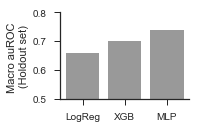

In [155]:
save_on = True
roc_plot = [roc_macro_all['logregModel_binsesh'],
            roc_macro_all['xgbModel_binsesh'],
            roc_macro_all['kerasModel_binsesh']]
fig = plt.figure()
ax = fig.add_axes([.2,.2,.3,.3])
ax.bar([1,2,3],roc_plot,facecolor=[.6,.6,.6])
ax.set_ylim([0.5,0.8])
ax.set_ylabel('Macro auROC \n(Holdout set)')
ax.set_xticks([1,2,3])
ax.set_xticklabels(['LogReg','XGB','MLP'])
sns.set_style("ticks")
sns.despine()
if save_on:
    plt.savefig('auROC.png',dpi=600,edgecolor='k')

# Plotting proportion new user booking by age bin.

In [27]:
#Load the data and generate features
debug = False
merge_classes = ['other','US','FR','CA','GB','ES','IT','PT','NL','DE','AU']
rm_classes = []
rescale_predictors = False
add_sessions = 'none'
training_data = '../data/train_users_2.csv'
test_data = '../data/test_users.csv'
add_logreg_filename = []
df_train, df_test, labels, id_train, id_test = feateng.feateng1(training_data,test_data,add_sessions,rm_classes,merge_classes,add_logreg_filename,rescale_predictors,debug)


Loading data...

Done
Feature engineering...
    formatting date_account_created...
    formatting timestamp_first_active
    formatting age
    one-hot-feature encoding


In [108]:
# bin observations by age, plot the proportion of new user bookings in each bin
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
label_names = ["10-20","20-30","30-40","40-50","50-60","60-70","70-80","80-90","90-100"]
categories = np.array(pd.cut(df_train['age'],bins, labels=label_names))
booked = np.array(labels['country_destination'] != 'NDF')
booked[~pd.isnull(categories)]
categories[~pd.isnull(categories)]

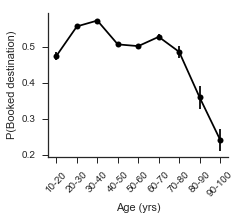

In [125]:
#plot the probability of a booking as a function of age bins
save_on = 1
    #compute mean and se for each bin
pBook = {'p':[],'n':[],'se':[]}
for l in label_names:
    p = np.mean(booked[categories==l])
    n = np.sum(~pd.isnull(booked[categories==l]))
    se = np.sqrt(p*(1-p)/n)
    pBook['p'].append(p)
    pBook['n'].append(n)
    pBook['se'].append(se)
    #plot it
fig = plt.figure(figsize=(5,4))    
ax = fig.add_axes([0.3,0.3,.5,.5])
ax.errorbar(range(len(label_names)),pBook['p'],yerr=pBook['se'],color='k',marker='.',markersize=12)
ax.set_xticks(range(len(label_names)))
ax.set_xticklabels(label_names,rotation=45)
ax.set_xlabel('Age (yrs)')
ax.set_ylabel('P(Booked destination)')
sns.set_style("ticks")
sns.despine()
#save
if save_on:
    plt.savefig('pBook_age_bins.png',dpi=600,edgecolor='k')